# Apple Stock Price Exploratory Data Analysis (EDA)

This project as mentioned in the readme.md intent is to develop a prediction model using transformers (TFT). 
To capture a crisis moment, we decide to start before covid-19 till the end of 2024. (2018-01-01 -- 2024-12-31)

In [1]:
import os
import datetime

import torch
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification


#### I. **Data Collection and Preparation**

In [2]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'NVDA', 'META'] # 
names = ['apple', 'google', 'microsoft', 'amazon', 'nvidia', 'meta'] # 

start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2024, 12, 31)

output_dir = 'stock_data'
if  not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Gathering Data
def collect_vix_of_market(start, end):
    indice_of_fear = yf.Ticker('^VIX')
    vix = indice_of_fear.history(start=start, end=end)
    print('Collecting VIX data')
    if vix.empty or vix is None:
       raise ValueError(f'No data found for {indice_of_fear} between {start} and {end}')
         
    if isinstance(vix.index, pd.MultiIndex):
        vix.columns = vix.columns.get_level_values(0)
    
    vix['Date'] = pd.to_datetime(vix.index)
    vix.set_index('Date', inplace=True)
    vix.index = vix.index.tz_localize(None)
    vix = vix[['Close']].rename(columns={'Close': 'VIX'})   
    vix.head()
    return vix


def collect_and_clean_historical_yf_stock_price(ticker, start, end):
     """This function retrieves stock data from Yahoo Finance
    Parameters:
        ticker (string): stock ticker
        start (string): start date
        end (string): end date
        """
     try:
         stock = yf.Ticker(ticker)
         
         data = stock.history(start=start, end=end)
         
         print(f'==>Collected columns from stock are {data.columns}')
         
         data.index = data.index.tz_localize(None)
         
         if data.empty or data is None:
             raise ValueError(f'No data found for {ticker} between {start} and {end}')
             
         if isinstance(data.index, pd.MultiIndex):
             data.columns = data.columns.get_level_values(0)
             
         data['Price_Change'] = data['Close'].diff()
         # print(data['Price_Change'].head(2))
         
         if 'Close' in data.columns:
             data['Daily_Return'] = data['Close'].pct_change() * 100
             data['Cumulative_Return'] = (1 + data['Close'].pct_change()).cumprod()
             # The Window is set to 21 because one month equals to 21-day trading which is commonly used
             data['Volatility'] = data['Daily_Return'].rolling(window=21).std()
             data['7_days_SMA'] = data['Close'].rolling(window=7).mean()
             data['30_days_SMA'] = data['Close'].rolling(window=30).mean()
             data['7_days_EMA'] = data['Close'].ewm(span=7, adjust=False).mean()
             data['30_days_EMA'] = data['Close'].ewm(span=30, adjust=False).mean()
             
             
         data['Gain'] = data['Price_Change'].apply(lambda x: x if x > 0 else 0)
         data['Loss'] = data['Price_Change'].apply(lambda x: -x if x < 0 else 0)
         
         period = 14
         data['Avg_Gain'] = data['Gain'].rolling(window=period).mean()
         data['Avg_Loss'] = data['Loss'].rolling(window=period).mean()
         
         for i in range(period, len(data)):
             data.loc[data.index[i], 'Avg_Gain'] = (data['Avg_Gain'].iloc[i-1] * (period - 1) + data['Gain'].iloc[i]) / period
             data.loc[data.index[i], 'Avg_Loss'] = (data['Avg_Loss'].iloc[i-1] * (period - 1) + data['Loss'].iloc[i]) / period
             # data['Avg_Gain'].iloc[i] = (data['Avg_Gain'].iloc[i-1] * (period - 1) + data['Gain'].iloc[i]) / period
             # data['Avg_Loss'].iloc[i] = (data['Avg_Loss'].iloc[i-1] * (period - 1) + data['Loss'].iloc[i]) / period
             
         data['RS'] = (data['Avg_Gain'] / data['Avg_Loss'])
         
         data[f'RSI_{period}'] = 100 - (100 / (1 + data['RS']))
         data[f'RSI_{period}'] = data[f'RSI_{period}'].replace([np.inf, -np.inf], np.nan)
         
         print(f"==>Stock price data from {start} to {end} collected successfully for {ticker}")
         
         # Dropping useless columns
         data = data.drop(['Dividends', 'Stock Splits', 'Gain', 'Loss', 'RS', 'Avg_Gain', 'Avg_Loss'], axis=1, errors='ignore')
         
         print(f'Joined dataset columns are {data.columns} we return {len(data)} observations')
         return data
     except Exception as e:
         print(f'Exception {e} happened during the try')
         return None
     
def save_data_to_excel(dataframe: pd.DataFrame, ticker_name, data_dir):
    # xlsx_name = ticker_name + '_2018_2024_data.xlsx'
    csv_name = ticker_name + '_2018_2024_data.csv'
    # xlsx_file = os.path.join(data_dir, xlsx_name)
    csv_file = os.path.join(data_dir, csv_name)
    
    print(f'==>Saving data to {csv_file}')

    if os.path.exists(csv_file):
        print(f'==>Excel File for {ticker_name} exists at {csv_file}. Overwriting...')
    else:
        print(f'==>Excel File for {ticker_name} does not exist, creating new file at {csv_file}')

    try:
        # dataframe.to_excel(xlsx_file, index=True, engine='openpyxl')
        dataframe.to_csv(csv_file, index=True)
    except Exception as e:
        print(f'==[{ticker_name}] Error {e}')
        

for i, stock_ticker in enumerate(tickers):
    print(f"==>Processing {stock_ticker} <==")
    df = collect_and_clean_historical_yf_stock_price(ticker=stock_ticker, start=start_date, end=end_date)
    vix_df = collect_vix_of_market(start=start_date, end=end_date)
    vix_df.info()
    df = df.join(vix_df['VIX'], how='left')
    if df is not None:
        df.head(2)
        save_data_to_excel(df, names[i], output_dir)
    else:
        print(f'Data frame is {df}')
    print('===================================')
    

## II. **The structure of Our data?**

In [4]:
apple = pd.read_csv(f"{output_dir}/apple_2018_2024_data.csv")

apple['Date'] = pd.to_datetime(apple['Date'], utc=True)
apple.set_index('Date', inplace=True)

In [5]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1760 entries, 2018-01-02 00:00:00+00:00 to 2024-12-30 00:00:00+00:00
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               1760 non-null   float64
 1   High               1760 non-null   float64
 2   Low                1760 non-null   float64
 3   Close              1760 non-null   float64
 4   Volume             1760 non-null   int64  
 5   Price_Change       1759 non-null   float64
 6   Daily_Return       1759 non-null   float64
 7   Cumulative_Return  1759 non-null   float64
 8   Volatility         1739 non-null   float64
 9   7_days_SMA         1754 non-null   float64
 10  30_days_SMA        1731 non-null   float64
 11  7_days_EMA         1760 non-null   float64
 12  30_days_EMA        1760 non-null   float64
 13  Avg_Gain           1747 non-null   float64
 14  Avg_Loss           1747 non-null   float64
 15  RSI_14             1747 

In [6]:
apple.head(10)

,Open,High,Low,Close,Volume,Price_Change,Daily_Return,Cumulative_Return,Volatility,7_days_SMA,30_days_SMA,7_days_EMA,30_days_EMA,Avg_Gain,Avg_Loss,RSI_14,VIX
Date,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00+00:00,39.986346,40.489230,39.774850,40.479828,102223600,NaN,NaN,NaN,NaN,NaN,NaN,40.479828,40.479828,NaN,NaN,NaN,9.77
2018-01-03 00:00:00+00:00,40.543284,41.017971,40.409341,40.472786,118071600,-0.007042,-0.017396,0.999826,NaN,NaN,NaN,40.478067,40.479374,NaN,NaN,NaN,9.15
2018-01-04 00:00:00+00:00,40.545634,40.764179,40.437540,40.660782,89738400,0.187996,0.464500,1.004470,NaN,NaN,NaN,40.523746,40.491077,NaN,NaN,NaN,9.22
2018-01-05 00:00:00+00:00,40.757123,41.210657,40.665476,41.123711,94640000,0.462929,1.138514,1.015906,NaN,NaN,NaN,40.673737,40.531892,NaN,NaN,NaN,9.22
2018-01-08 00:00:00+00:00,40.970970,41.267060,40.872270,40.970970,82271200,-0.152740,-0.371417,1.012133,NaN,NaN,NaN,40.748045,40.560220,NaN,NaN,NaN,9.52
2018-01-09 00:00:00+00:00,41.017973,41.137818,40.750081,40.966274,86336000,-0.004696,-0.011462,1.012017,NaN,NaN,NaN,40.802603,40.586417,NaN,NaN,NaN,10.08
2018-01-10 00:00:00+00:00,40.691336,40.959227,40.653736,40.956875,95839600,-0.009399,-0.022944,1.011785,NaN,40.804461,NaN,40.841171,40.610318,NaN,NaN,NaN,9.82
2018-01-11 00:00:00+00:00,41.027380,41.238876,41.003883,41.189526,74670800,0.232651,0.568038,1.017532,NaN,40.905846,NaN,40.928259,40.647686,NaN,NaN,NaN,9.88
2018-01-12 00:00:00+00:00,41.401013,41.678306,41.276467,41.614857,101672400,0.425331,1.032620,1.028039,NaN,41.068999,NaN,41.099909,40.710084,NaN,NaN,NaN,10.16


In [7]:
null_count_stats = apple.isnull().sum()
print(f'Null Count Details\n')
null_count_stats

Null Count Details



Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Price_Change          1
Daily_Return          1
Cumulative_Return     1
Volatility           21
7_days_SMA            6
30_days_SMA          29
7_days_EMA            0
30_days_EMA           0
Avg_Gain             13
Avg_Loss             13
RSI_14               13
VIX                   0
dtype: int64

In [8]:
apple.describe()

,Open,High,Low,Close,Volume,Price_Change,Daily_Return,Cumulative_Return,Volatility,7_days_SMA,30_days_SMA,7_days_EMA,30_days_EMA,Avg_Gain,Avg_Loss,RSI_14,VIX
count,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03,1759.000000,1759.000000,1759.000000,1739.000000,1754.000000,1731.000000,1760.000000,1760.000000,1747.000000,1747.000000,1747.000000,1760.000000
mean,122.071003,123.406105,120.844046,122.194373,1.001781e+08,0.120206,0.122512,3.019796,1.757473,122.106169,121.817569,121.830528,120.508868,0.844422,0.726753,55.487449,19.871136
std,59.184229,59.728982,58.693705,59.258941,5.521652e+07,2.289424,1.924687,1.463537,0.817474,58.959007,57.923448,59.031241,58.321827,0.437749,0.469577,12.767520,7.713274
min,34.342203,34.757230,33.869933,33.915253,2.323470e+07,-10.554520,-12.864714,0.837831,0.607222,35.728011,36.920058,36.020093,37.796841,0.085013,0.057904,20.851106,9.150000
25%,54.455931,54.965782,53.885814,54.262263,6.308165e+07,-0.892466,-0.804580,1.343003,1.221852,54.066038,56.068293,53.800538,52.586314,0.414051,0.345940,45.281804,14.477500
50%,132.216058,133.304495,130.497942,131.866173,8.674660e+07,0.116875,0.128467,3.257837,1.582835,132.069245,132.547206,132.146415,130.542081,0.853525,0.639545,56.566762,18.040001
75%,169.004026,170.781601,167.770233,169.228806,1.214590e+08,1.162624,1.151181,4.180571,2.062577,169.529099,167.810774,169.163255,166.750563,1.161376,1.033356,64.966516,22.892499
max,257.906429,259.814335,257.347047,258.735504,4.265100e+08,13.983002,11.980856,6.391715,6.718535,254.657155,242.874297,254.605831,245.065181,2.268216,2.575222,85.724507,82.690002


## III. **Evolution of the stock prices over time**

### 3.1-High- & Low-Volatility Calculation

In [9]:
# We want to set the top 10% volatility period
threshold = apple['Volatility'].quantile(0.9)
low_threshold = apple['Volatility'].quantile(0.1)

#### 3.1.a Low-Volatility Calculation

In [10]:
low_volatility = apple[apple['Volatility'] < low_threshold]

low_volatility[['Close', 'Volatility' ]]

,Close,Volatility
Date,,
2018-02-01 00:00:00+00:00,39.427071,0.925297
2018-06-05 00:00:00+00:00,45.787525,0.713226
2018-06-06 00:00:00+00:00,45.946217,0.705695
2018-06-07 00:00:00+00:00,45.823059,0.711950
2018-06-08 00:00:00+00:00,45.406181,0.742065
...,...,...
2024-12-20 00:00:00+00:00,254.210510,0.880819
2024-12-23 00:00:00+00:00,254.989655,0.866899
2024-12-24 00:00:00+00:00,257.916443,0.877244


#### 3.1.b High-Volatility Calculation

In [11]:
high_volatility = apple[apple['Volatility'] > threshold]

high_volatility[['Close', 'Volatility']]

,Close,Volatility
Date,,
2018-11-20 00:00:00+00:00,42.213383,2.817812
2018-11-21 00:00:00+00:00,42.165676,2.790899
2018-11-28 00:00:00+00:00,43.157925,2.904438
2018-11-29 00:00:00+00:00,42.826382,2.891414
2018-11-30 00:00:00+00:00,42.595028,2.787898
...,...,...
2022-11-30 00:00:00+00:00,146.328629,2.998286
2022-12-01 00:00:00+00:00,146.605392,2.975158
2022-12-02 00:00:00+00:00,146.111176,2.853527


### 3.2 Evolution of Price chart and detection of volatility trend from 2018 to 2024

The intent behind this plot is to see if there's a correlation between high- & Low-volatility moment and our stock's chart.
Is during high-volatility the close price has an uptrend or downtrend?
How much do those indicators affect the stock market and our closing price?

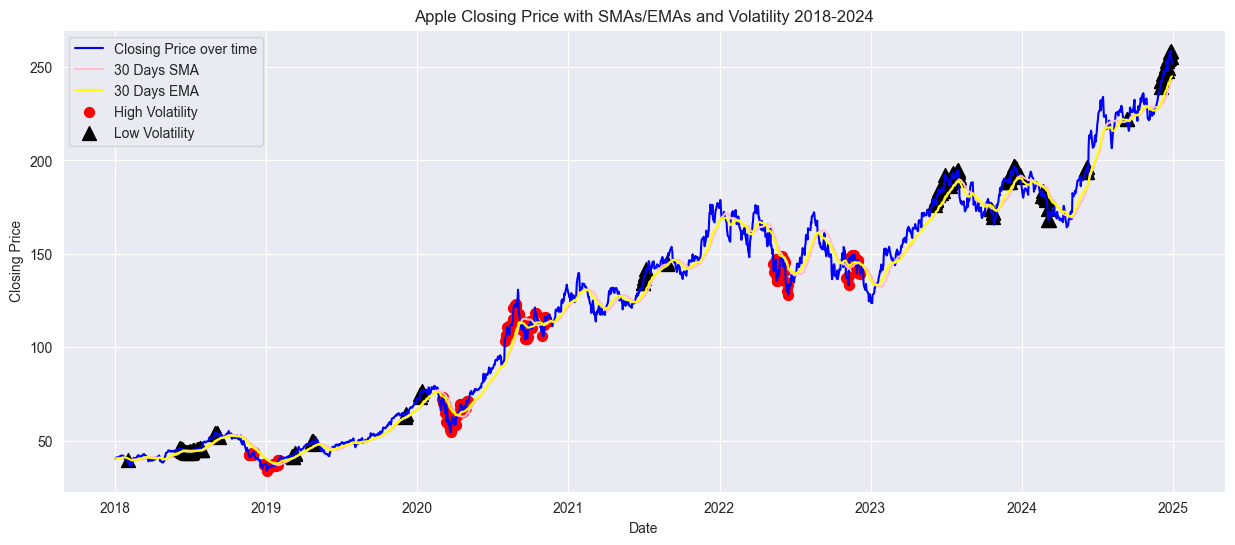

In [13]:
plt.figure(figsize=(15,6))
# sns.lineplot(data=apple['Close'])
plt.plot(apple.index, apple['Close'], label='Closing Price over time', color='blue')
plt.plot(apple.index, apple['30_days_SMA'], label='30 Days SMA', color='pink')
plt.plot(apple.index, apple['30_days_EMA'], label='30 Days EMA', color='yellow')
plt.scatter(high_volatility.index, high_volatility['Close'], label='High Volatility', color='red', marker='o', s=50)
plt.scatter(low_volatility.index, low_volatility['Close'], label='Low Volatility', color='black' , marker='^', s=100)
plt.title('Apple Closing Price with SMAs/EMAs and Volatility 2018-2024')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

## IV- Analysis Of Stock's Returns

Here we're supposed to check approximately how much or how the return of our stock goes over time

In [14]:
apple['Log_Return'] = np.log(apple['Close'] / apple['Close'].shift(1))

apple['Log_Return'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1760 entries, 2018-01-02 00:00:00+00:00 to 2024-12-30 00:00:00+00:00
Series name: Log_Return
Non-Null Count  Dtype  
--------------  -----  
1759 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB


### 4.1-Daily Return & Cumulative Return

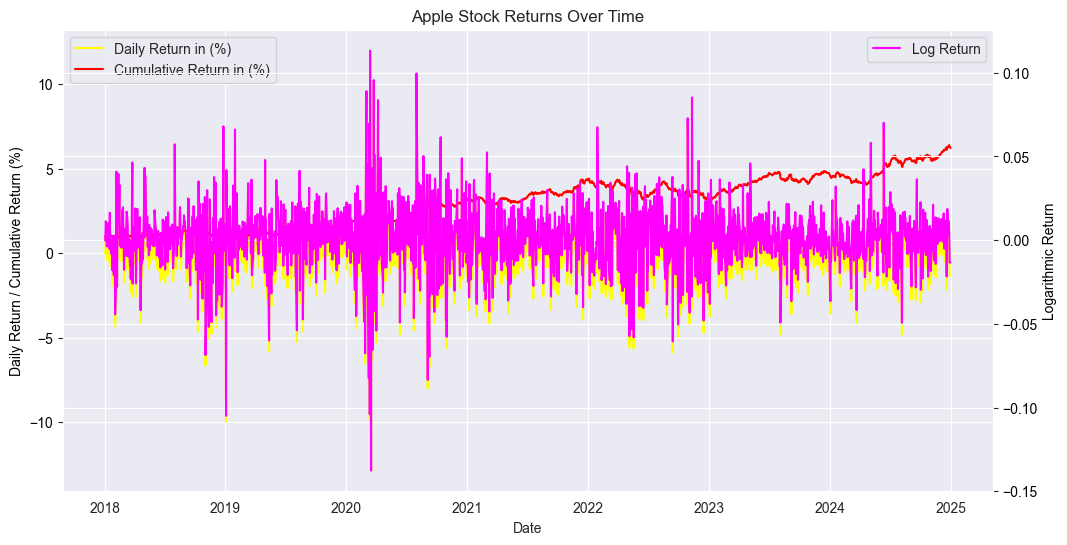

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot()
ax1.plot(apple.index, apple['Daily_Return'], label='Daily Return in (%)', color='yellow')
ax1.plot(apple.index, apple['Cumulative_Return'], label='Cumulative Return in (%)', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return / Cumulative Return (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(apple.index, apple['Log_Return'], label='Log Return', color='magenta')
ax2.set_ylabel('Logarithmic Return', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Apple Stock Returns Over Time')
plt.show()                                           

### 4.2-Logarithmic Return

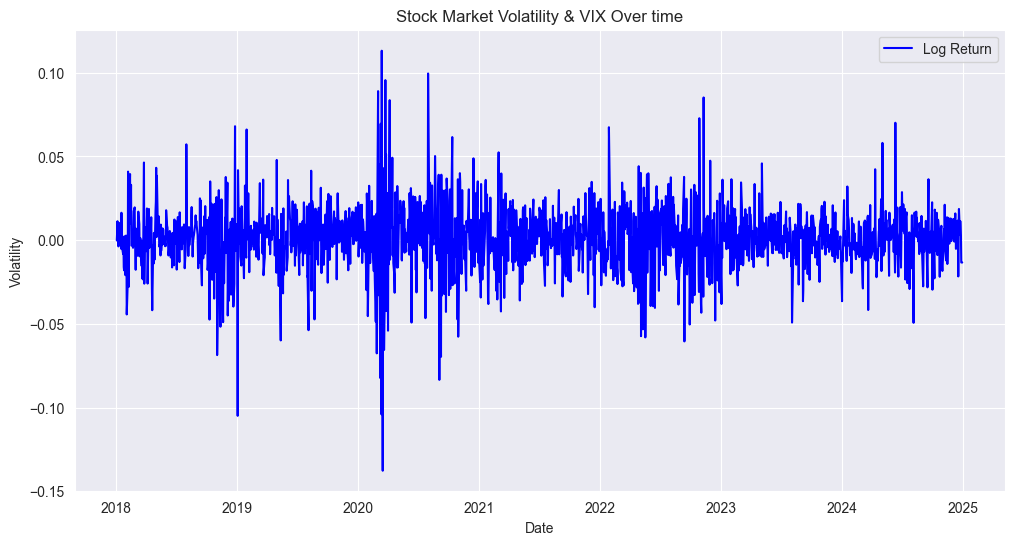

In [17]:
plt.figure(figsize=(12,6))
plt.plot(apple.index, apple['Log_Return'], label='Log Return', color='blue')
# plt.plot(apple.index, apple['VIX'], label='Indice Of Fear', color='red')
plt.title('Stock Market Volatility & VIX Over time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### 4.3 Indice Of Fear Plot (VIX)

This indice measure the global sentiment of traders and investors on the marker in general

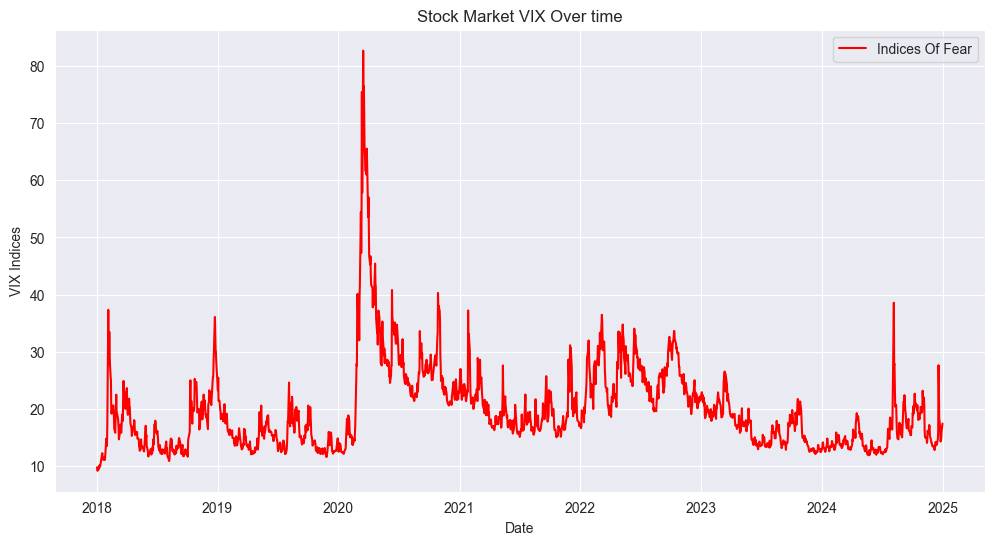

In [18]:
plt.figure(figsize=(12,6))
# plt.plot(apple.index, apple['Volatility'], label='Volatility', color='blue')
plt.plot(apple.index, apple['VIX'], label='Indices Of Fear', color='red')
plt.title('Stock Market VIX Over time')
plt.xlabel('Date')
plt.ylabel('VIX Indices')
plt.legend()
plt.show()

On the indice of Fear plot we can notice some peaks, early and lastly of 2018's. During the first trimester of 2020 we notice the highest peak of VIX indice which may be the same moment when covid-19 where declared as a pandemic disease but it didn't last for too long before dropping down.

### V- Years Grouping for more focused study

We're working on large dataset 2018-2024, and it includes a lot of impactful events.
So for better analysis, we have to restructure this period in a way that aligns well with key economic and geopolitical events that have affected the stock market over this period, particularly for Apple (AAPL). This grouping allows us to analyze distinct phases of market behavior in relation to the COVID-19 pandemic and other significant events like the Ukraine war. Let’s break down the rationale for each group, assess the approach.


 - 2018–2019: Pre-Covid period, and baseline stock performance before events
 - 2020–2021: Isolate the dramatic impact of the pandemic, including the crash and recovery.
 - 2022–2023: Focus on the transition period, capturing the Ukraine war’s effects and market correction.
 - 2024: Examine the post-COVID normalization phase.

### 5.1- Period Grouping

In [19]:
apple['Year'] = apple.index.year
def map_year_to_group(year):
    if year in [2018, 2019]:
        return '2018-2019'
    elif year in [2020, 2021]:
        return '2020-2021'
    elif year in [2022, 2023]:
        return '2022-2023'
    elif year == 2024:
        return '2024'
    return None

apple['Year_Group'] = apple['Year'].apply(map_year_to_group)

print("Year_Group distribution:")
print(apple['Year_Group'].value_counts())

Year_Group distribution:
Year_Group
2020-2021    505
2018-2019    503
2022-2023    501
2024         251
Name: count, dtype: int64


In [20]:
def technical_indicators_group_plot(data, year_range):
    periodic_data = data[data['Year_Group'] == year_range].copy()

    # Skip if the year group has no data
    if periodic_data.empty:
        print(f"No data for year group {year_range}, skipping...")

    # Debug: Check the size of periodic_data
    print(f"\nYear Group {year_range}: {len(periodic_data)} rows")
    print(f"Date range: {periodic_data.index.min()} to {periodic_data.index.max()}")

    # Define high and low volatility thresholds for the current year group
    high_volatility_threshold = periodic_data['Volatility'].dropna().quantile(0.9)
    low_volatility_threshold = periodic_data['Volatility'].dropna().quantile(0.1)

    # Identify high and low volatility periods for the current year group
    high_volatility = periodic_data[periodic_data['Volatility'] > high_volatility_threshold]
    low_volatility = periodic_data[periodic_data['Volatility'] < low_volatility_threshold]

    # Print thresholds for reference
    print(f"Year Group {year_range}:")
    print(f"High Volatility Threshold (90th percentile): {high_volatility_threshold:.2f}")
    print(f"Low Volatility Threshold (10th percentile): {low_volatility_threshold:.2f}")
    print(f"High volatility periods: {len(high_volatility)}")
    print(f"Low volatility periods: {len(low_volatility)}")
 
    # Create a figure with 4 subplots (4 rows, 1 column) for the current year group
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16), sharex=True)

    # Subplot 1: Closing Price with SMAs/EMAs and Volatility Markers
    axes[0].plot(periodic_data.index, periodic_data['Close'], label='Closing Price', color='blue')
    axes[0].plot(periodic_data.index, periodic_data['30_days_EMA'], label='30-Day EMA', color='orange')
    axes[0].plot(periodic_data.index, periodic_data['30_days_SMA'], label='30-Day SMA', color='green')
    axes[0].scatter(high_volatility.index, high_volatility['Close'], label='High Volatility', color='black', marker='o', s=50)
    axes[0].scatter(low_volatility.index, low_volatility['Close'], label='Low Volatility', color='olive', marker='^', s=100)
    axes[0].set_title(f'Apple Closing Price with SMAs/EMAs and Volatility ({year_range})')
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='upper left')
    axes[0].grid(True)

    # Subplot 2: RSI (14-Day)
    axes[1].plot(periodic_data.index, periodic_data['RSI_14'], label='Relative Strength Index (14-Day)', color='cyan')
    axes[1].axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
    axes[1].axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
    axes[1].set_title(f'RSI (14-Day) ({year_range})')
    axes[1].set_ylabel('RSI')
    axes[1].legend(loc='upper left')
    axes[1].grid(True)

    # Subplot 3: VIX and Volatility with Dual Y-Axes
    ax3 = axes[2]
    ax3_twin = ax3.twinx()

    # Plot VIX on the left y-axis
    ax3.plot(periodic_data.index, periodic_data['VIX'], label='Market Indices of Fear (VIX)', color='red')
    ax3.set_ylabel('VIX', color='red')
    ax3.tick_params(axis='y', labelcolor='red')

    # Plot Volatility on the right y-axis
    ax3_twin.plot(periodic_data.index, periodic_data['Volatility'], label='Apple Volatility', color='purple')
    ax3_twin.set_ylabel('Apple Volatility', color='purple')
    ax3_twin.tick_params(axis='y', labelcolor='purple')

    # Add title and legend
    ax3.set_title(f'Market Indices of Fear (VIX) and Apple Volatility ({year_range})')
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax3.grid(True)

    # Subplot 4: Log Returns (scaled by 100 for readability)
    axes[3].plot(periodic_data.index, periodic_data['Log_Return'] * 100, label='Log Return (%)', color='purple')
    axes[3].set_title(f'Log Returns (%) ({year_range})')
    axes[3].set_ylabel('Log Return (%)')
    axes[3].set_xlabel('Date')
    axes[3].legend(loc='upper left')
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()

### 5.2 - 2018–2019: Pre-COVID Market Trend 
(Understand Apple’s baseline performance before COVID)

- **Context**:  
  This period represents a relatively stable market environment before the COVID-19 pandemic. Global markets, including Apple’s stock, experienced steady growth with typical volatility driven by trade tensions (e.g., U.S.-China trade war) and economic cycles, but no major global health crises.

- **Market Behavior**:  
  Apple’s stock likely showed consistent upward trends, with volatility driven by company-specific factors (e.g., iPhone sales, product launches) and broader market sentiment. Volatility was generally lower compared to later periods, as seen in your earlier analysis where annualized volatility for Apple was around **15%–30%** in stable years.

- **Purpose**:  
  This group serves as a baseline to understand Apple’s stock behavior before the pandemic disrupted global markets.


Year Group 2018-2019: 503 rows
Date range: 2018-01-02 00:00:00+00:00 to 2019-12-31 00:00:00+00:00
Year Group 2018-2019:
High Volatility Threshold (90th percentile): 2.57
Low Volatility Threshold (10th percentile): 0.96
High volatility periods: 49
Low volatility periods: 49


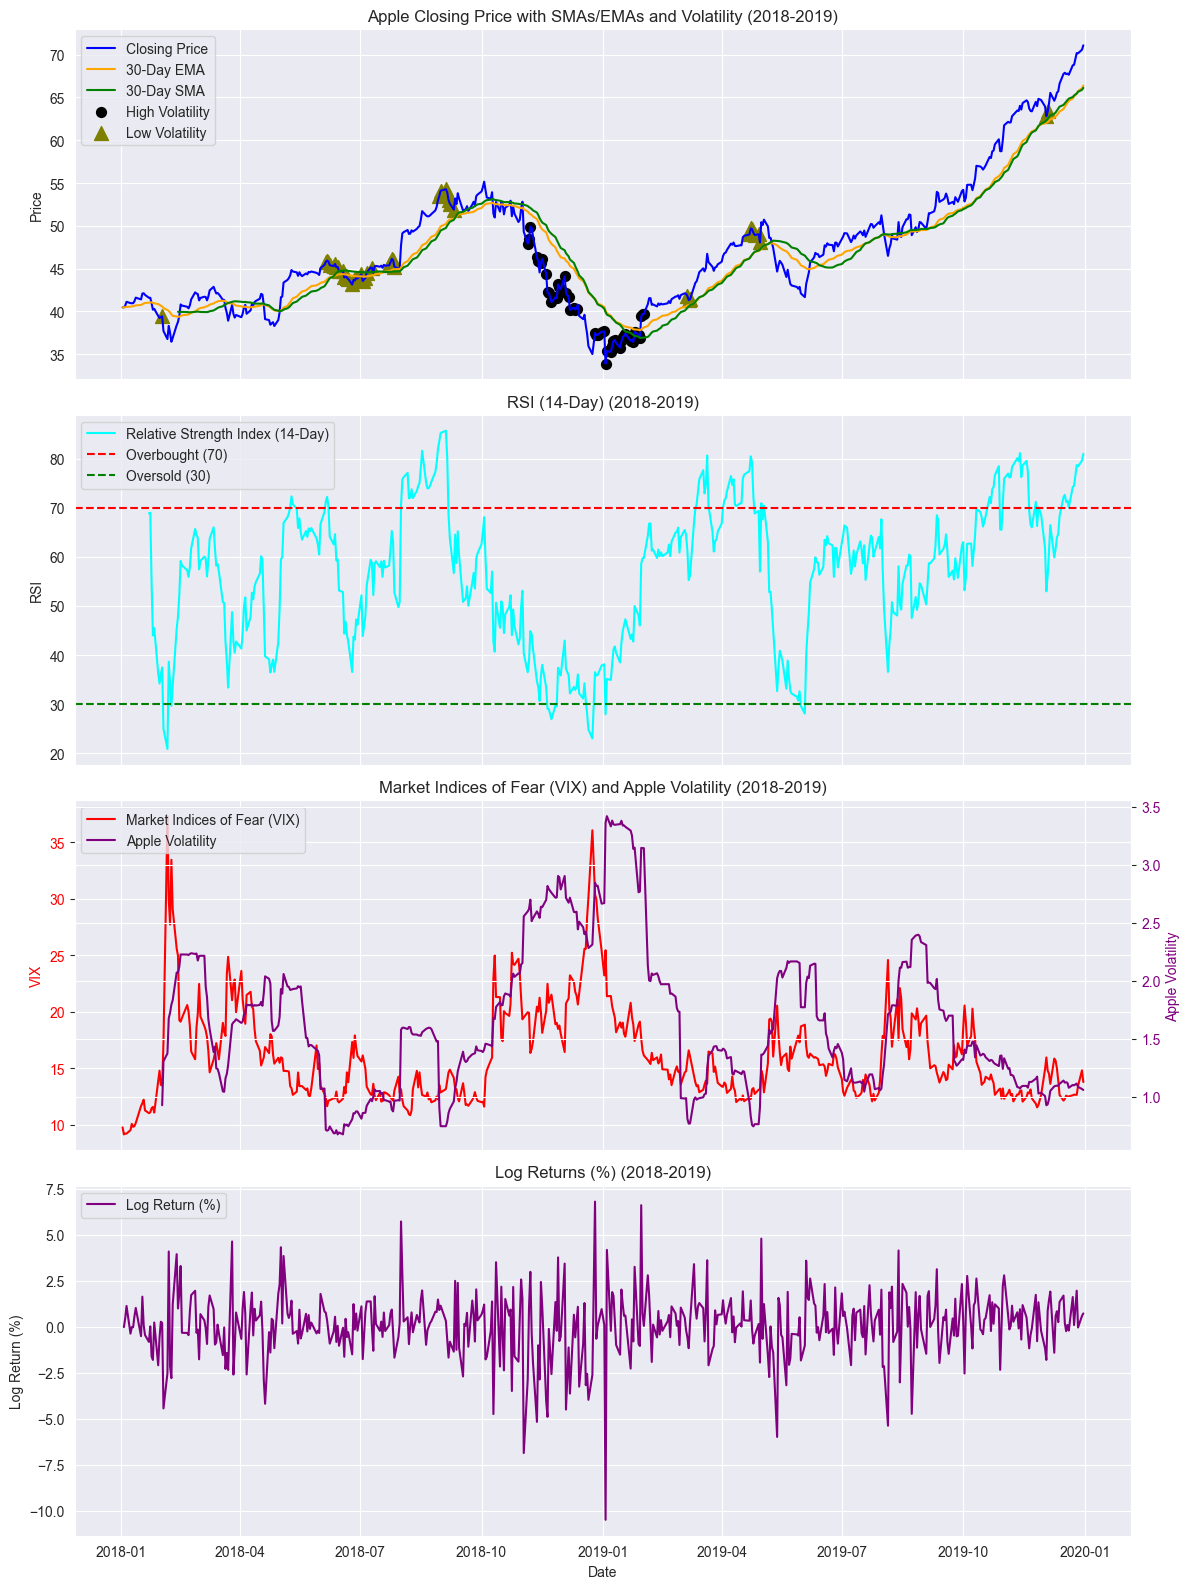

In [21]:
technical_indicators_group_plot(apple, '2018-2019')

### === Observations for 2018-2019 ===
Context: This period represents the pre-COVID market trend, a relatively stable time for Apple (AAPL).
Observation: Apple’s stock shows steady growth, with low volatility (mostly below the 90th percentile).
RSI remains mostly neutral (30–70), indicating stable momentum. VIX and Apple volatility are low, reflecting a calm market.
Log returns show small daily fluctuations, typical of a stable period.

### 5.3 - 2020–2021: Peak COVID Effects

- **Context**:  
  This period captures the height of the COVID-19 pandemic’s impact on the stock market. The first case of COVID-19 was identified in November 2019, but the market reaction began in late February 2020, with a sharp crash starting February 20, 2020, as discussed earlier. The S&P 500 dropped **34%** by March 23, 2020, and volatility spiked (e.g., **VIX peaked above 80** in March 2020).


- **Market Behavior**:  
  Apple’s stock experienced extreme volatility in 2020, with a significant drop during the March crash (e.g., Apple fell from around $81 to $56 per share, adjusted for a 4:1 split in August 2020). However, it recovered quickly due to stimulus measures, low interest rates, and a surge in demand for tech products as remote work and digital services boomed. By 2021, Apple’s stock soared, reaching new highs (e.g., closing at **$182** by late 2021), driven by strong earnings and market optimism. Volatility remained elevated compared to pre-COVID levels, with your data showing annualized volatility for Apple reaching 50%–100% during the 2020's turbulent periods.


- **Purpose**:  
  This group highlights the market’s reaction to the pandemic, including the initial crash, rapid recovery, and sustained growth amidst ongoing uncertainty.


Year Group 2020-2021: 505 rows
Date range: 2020-01-02 00:00:00+00:00 to 2021-12-31 00:00:00+00:00
Year Group 2020-2021:
High Volatility Threshold (90th percentile): 3.29
Low Volatility Threshold (10th percentile): 1.08
High volatility periods: 51
Low volatility periods: 51


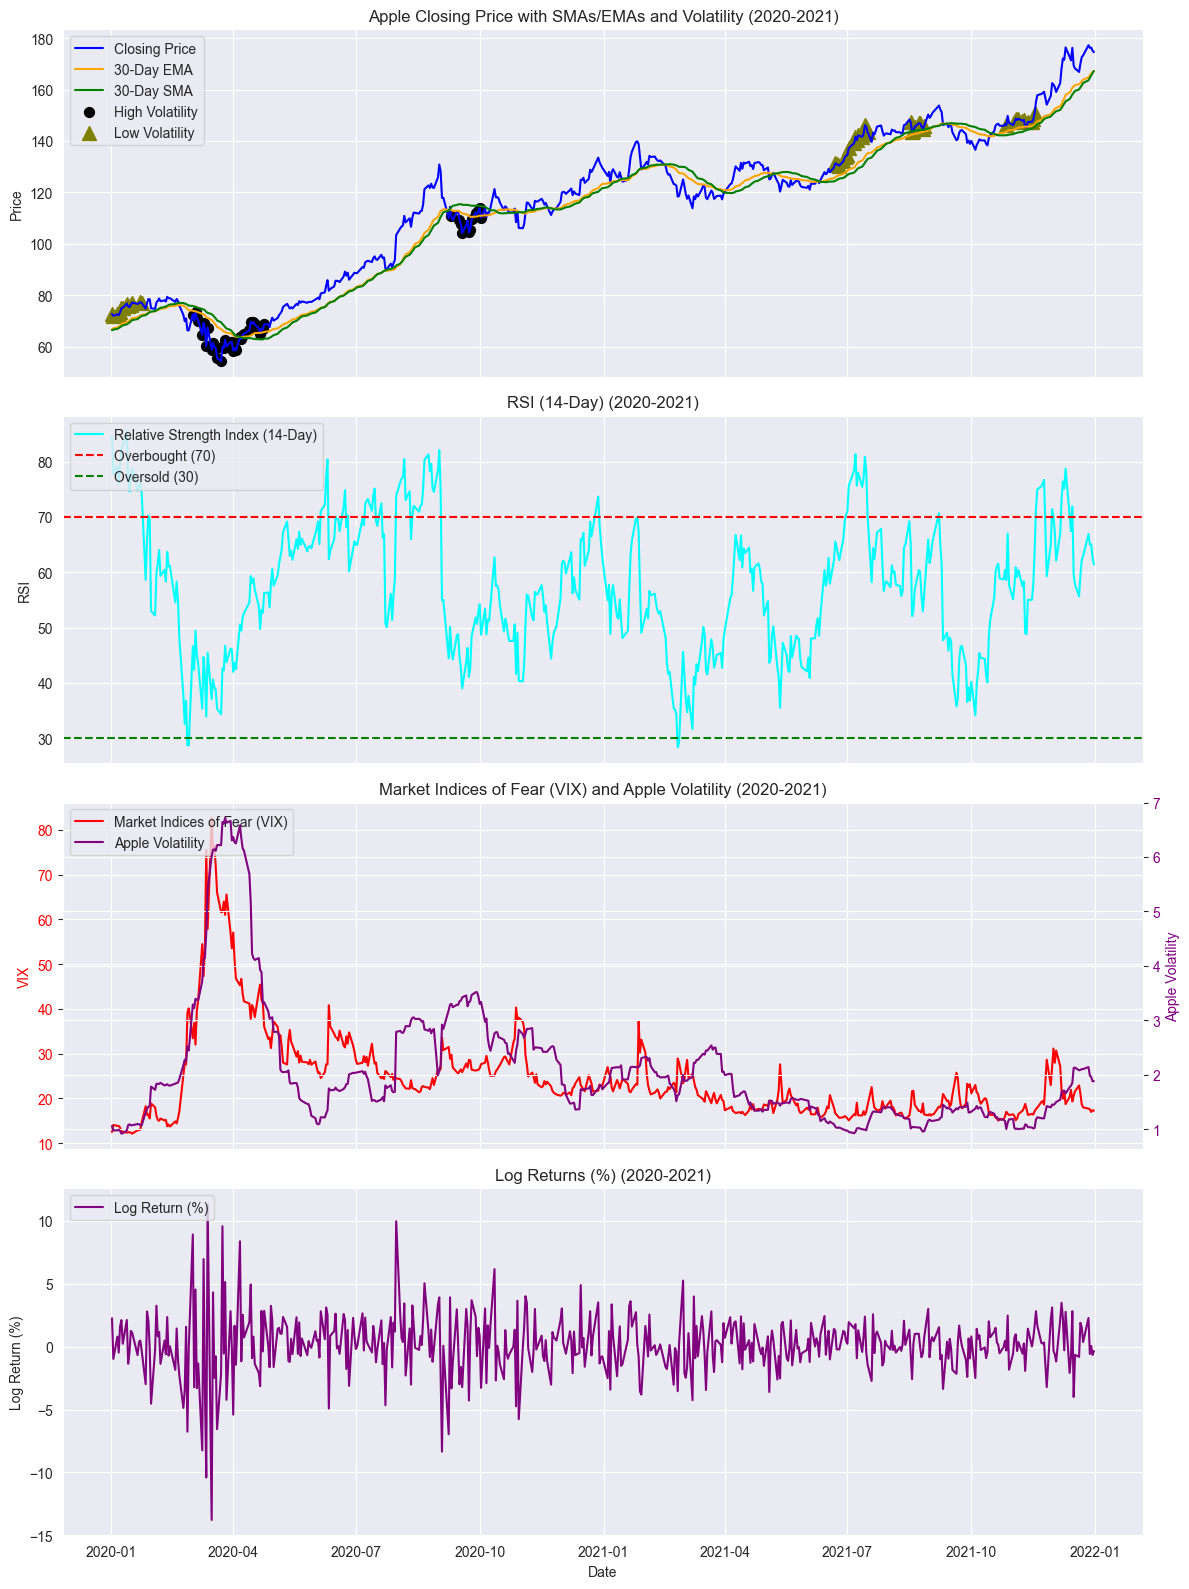

In [22]:
technical_indicators_group_plot(apple, '2020-2021')

###  === Observations for 2020-2021 ===
Observation: The March 2020 crash is clear, with a sharp price drop and high volatility markers. RSI drops below 30 (oversold) in March 2020, then rises above 70 (overbought) in 2021 during the recovery. VIX spikes above 80 in March 2020, and Apple volatility peaks, reflecting market panic. Log returns show large spikes during the crash.

### 5.4 - 2022–2023: Transition Period and Ukraine War

- **Context**:  
  This period marks a transition as the world moved past the acute phase of the pandemic, but new challenges emerged, notably the Russia-Ukraine war, which began on February 24, 2022. The war caused energy price shocks, supply chain disruptions, and inflationary pressures, contributing to a market correction. The S&P 500 entered a bear market in 2022, declining over **20%** from its January 2022 peak.


- **Market Behavior**:  
  Apple’s stock faced headwinds in 2022, dropping from its late 2021 peak of $182 to around $130 by mid 2022, driven by inflation fears, rising interest rates (Federal Reserve rate hikes began in March 2022), and supply chain issues, particularly in China.  Volatility remained elevated, though not as extreme as in 2020. In 2023, Apple rebounded, reaching new highs (e.g., $198 by  December 2023), as inflation moderated and the tech sector regained favor. The Ukraine war’s impact on energy prices and global  trade likely influenced Apple’s supply chain costs and investor sentiment.
  
  
- **Purpose**:  
  This group captures the market’s adjustment to post-COVID realities, compounded by geopolitical tensions, providing insight into how Apple navigated these challenges.


Year Group 2022-2023: 501 rows
Date range: 2022-01-03 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Year Group 2022-2023:
High Volatility Threshold (90th percentile): 2.73
Low Volatility Threshold (10th percentile): 0.94
High volatility periods: 50
Low volatility periods: 50


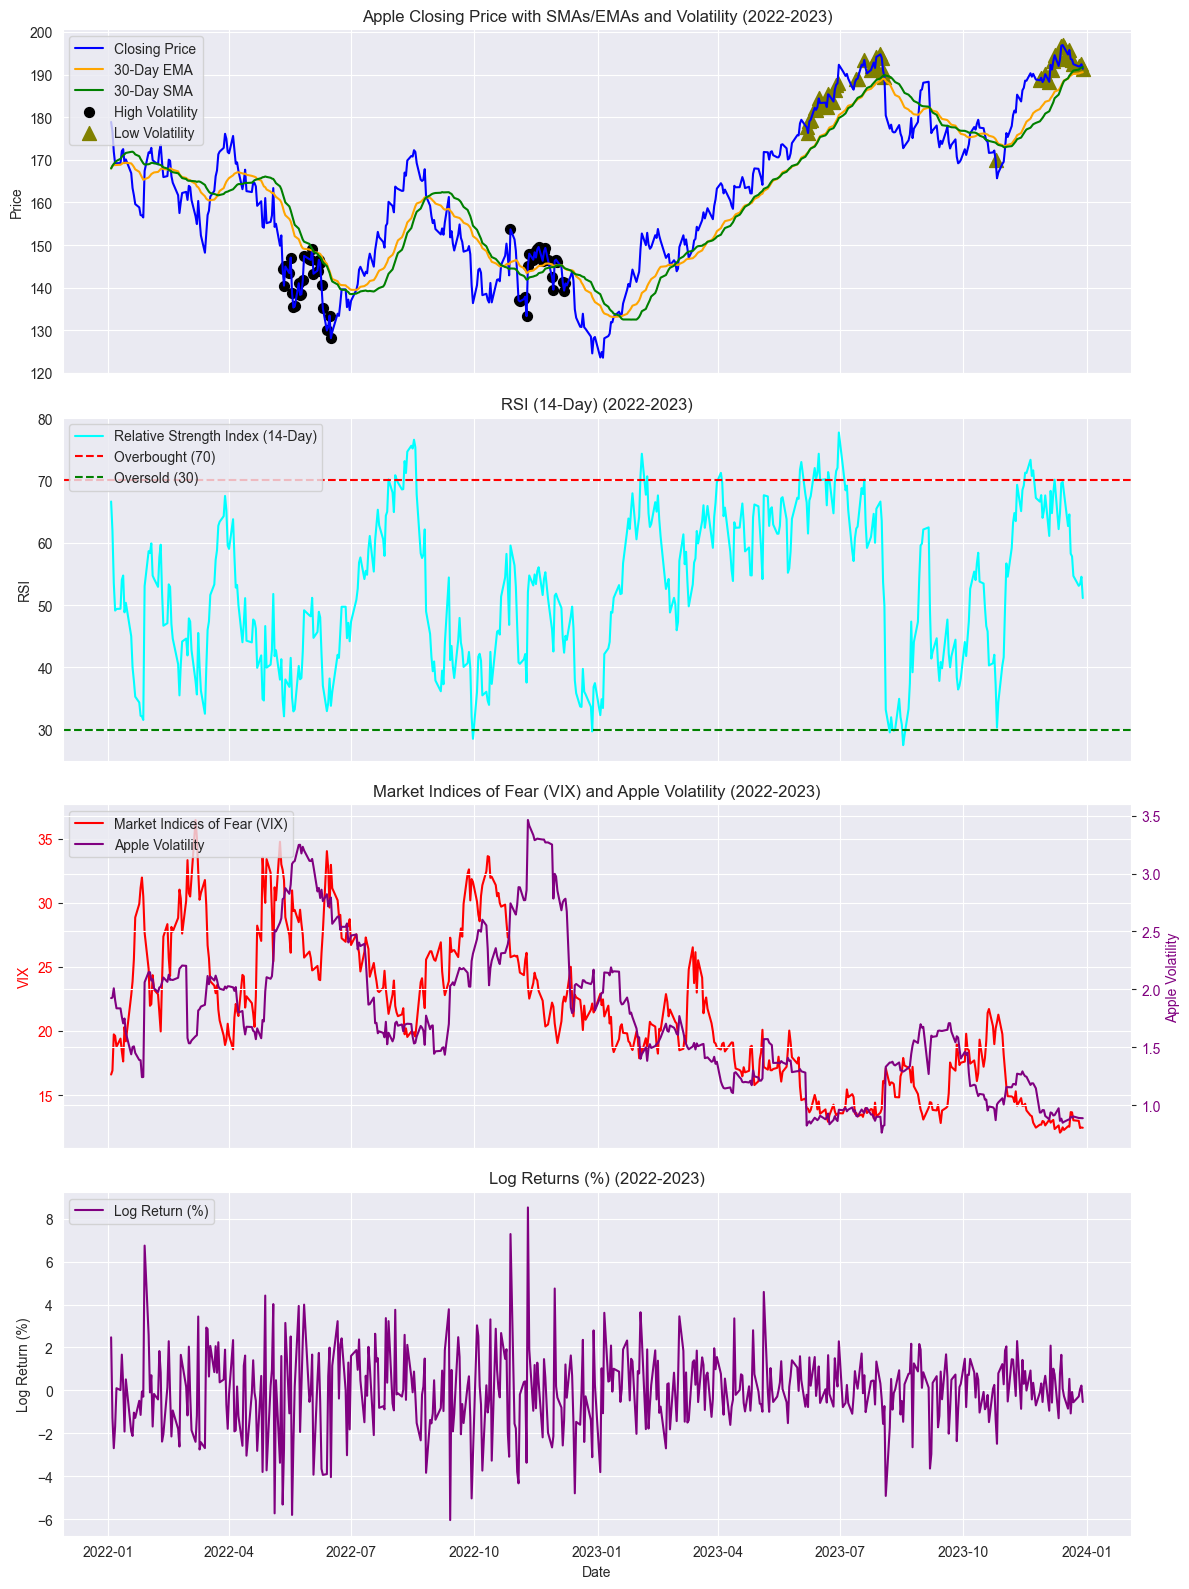

In [35]:
technical_indicators_group_plot(apple, '2022-2023')

###  === Observations for 2022-2023 ===
Observation: A market correction in 2022 leads to a price decline, followed by recovery in 2023. RSI dips below 30 in 2022, indicating oversold conditions, and recovers in 2023. Volatility is moderate, with VIX elevated due to the Ukraine war. Log returns show increased fluctuations in 2022, stabilizing in 2023.

### 5.5 - 2024: Post-COVID Effects


- **Context**:
  By 2024, the direct effects of COVID-19 on markets had largely subsided, with the WHO declaring the end of the global health emergency on May 5, 2023. However, the economic aftermath—such as inflation, interest rate hikes, and shifts in consumer behavior—continued to shape market dynamics.
  
  
- **Market Behavior**: 
  Apple’s stock in 2024 likely reflected a more normalized environment, with volatility returning to pre-COVID levels (e.g., 15%–30% annualized, based on your earlier volatility range). Growth may have been driven by new product launches (e.g., Apple Vision Pro, AI initiatives) and a stabilizing global economy, though challenges like inflation and geopolitical risks (e.g., ongoing Ukraine conflict, U.S.-China tensions) could still impact sentiment. Your data ends on December 31, 2024, so this group covers the full year.
  

- **Purpose**: 
  This group examines Apple’s performance in a post-COVID world, highlighting long-term shifts in market behavior and investor confidence


Year Group 2024: 251 rows
Date range: 2024-01-02 00:00:00+00:00 to 2024-12-30 00:00:00+00:00
Year Group 2024:
High Volatility Threshold (90th percentile): 1.84
Low Volatility Threshold (10th percentile): 0.90
High volatility periods: 25
Low volatility periods: 25


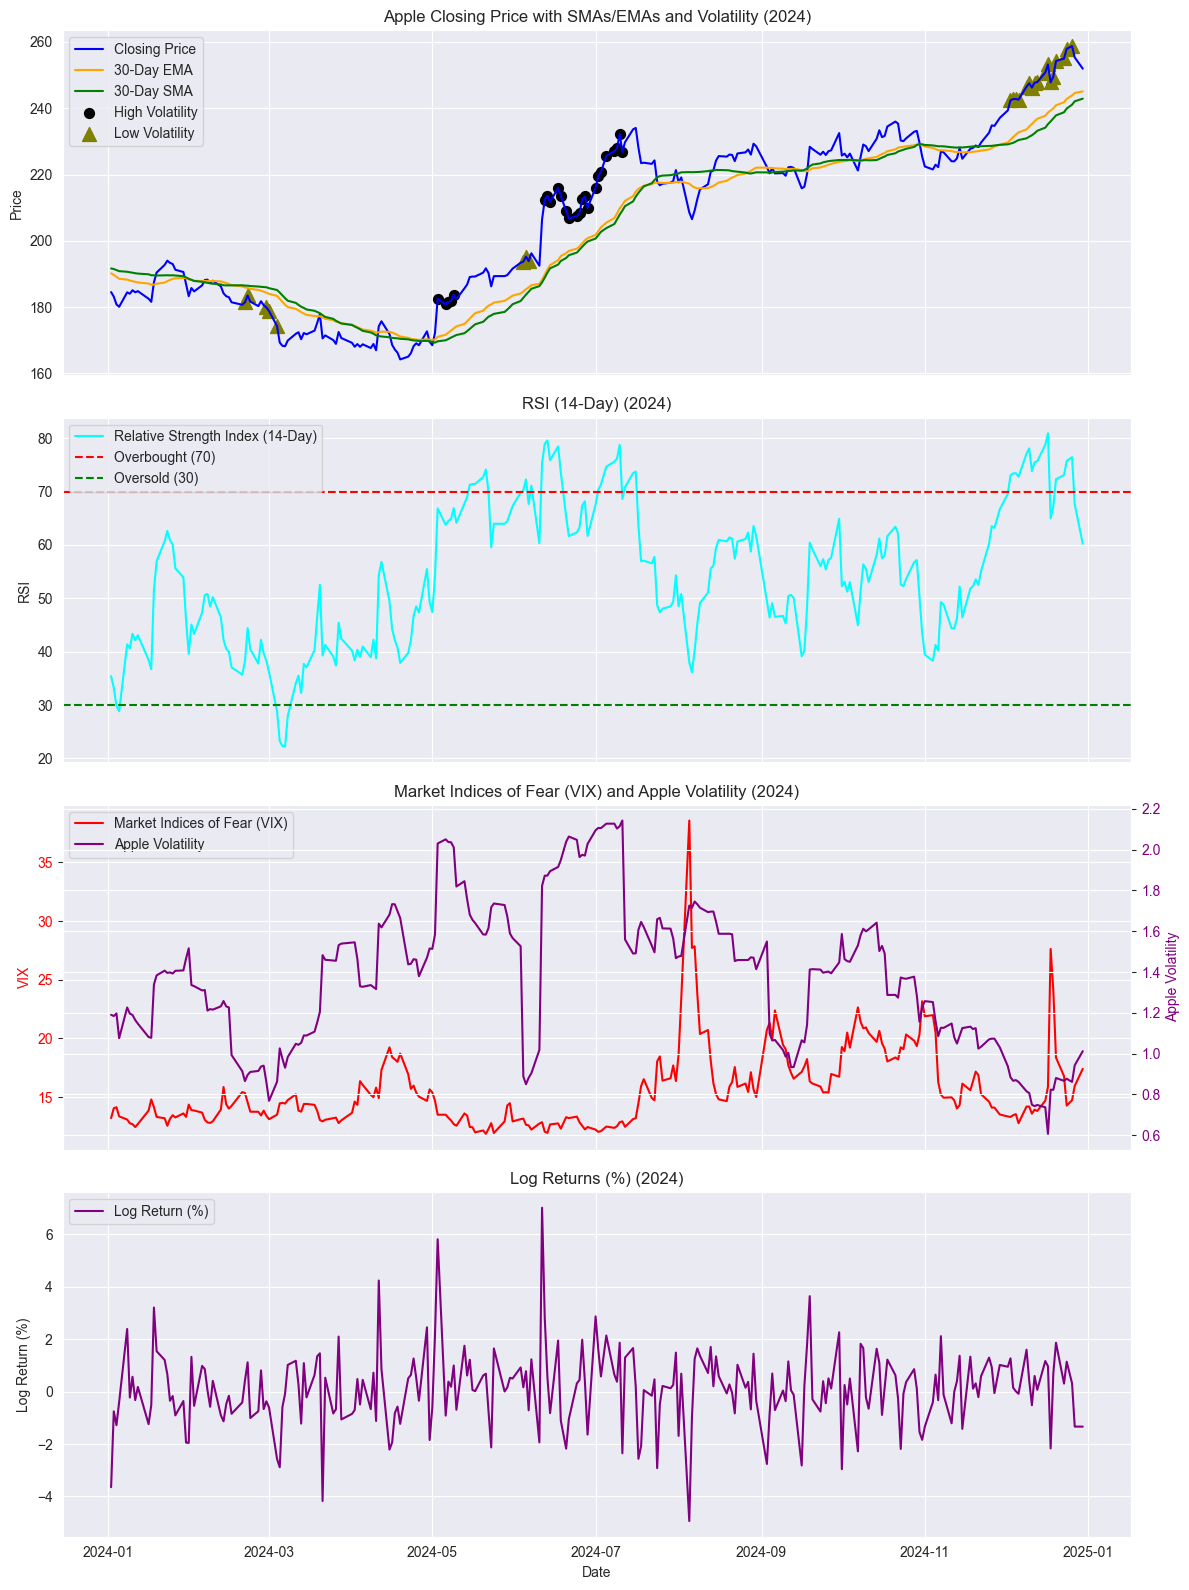

In [23]:
technical_indicators_group_plot(apple, '2024')

###  === Observations for 2024 ===
Observation: Apple’s stock shows a more stable trend, with fewer high-volatility markers. RSI remains mostly neutral (30–70), reflecting normalized market conditions. VIX and Apple volatility return to pre-COVID levels. Log returns are more stable, indicating a return to normal market behavior.

## VI - Trends And Seasonality

In [39]:
from statsmodels.stats.diagnostic import het_goldfeldquandt
import statsmodels.api as sm

apple['Time'] = np.arange(len(apple))

X = sm.add_constant(apple['Time'])
model = sm.OLS(apple['Close'], X).fit()
residuals = model.resid

gq_test = het_goldfeldquandt(residuals, X)
print('Goldfeld-Quandt Test:')
print(f'F-statistic: {gq_test[0]}')
print(f'p-value: {gq_test[1]}')

Goldfeld-Quandt Test:
F-statistic: 1.6379234735414179
p-value: 1.7739667976517782e-13


#### Since we have increasing variance meaning p-value < 0.05, F-statistic > 1 Multiplicative model is best suitable for seasonal decomposition

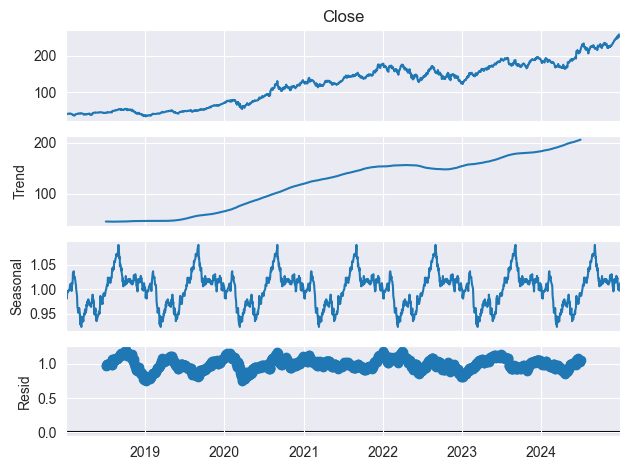

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(apple['Close'], model='multiplicative', period=252)  # 252 trading days ~ 1 year
decomposition.plot()
plt.show()

### Outliers by periods

Now it's time to look for Outliers in our dataset. before choosing beween IQR and ZSCORE method we have to run some test to check the normality of our dataset over periods. Convenient test it the one of **SHAPIRO-WILK**

In [41]:
from scipy.stats import shapiro

columns_to_test = ['Volume', 'Price_Change', 'Daily_Return', 'Cumulative_Return', 'Log_Return', 'Volatility', 'Avg_Gain', 'Avg_Loss',
       'RSI_14', 'VIX']

for col in columns_to_test:
    stat, p = shapiro(apple[col].dropna())
    print(f'Shapiro-Wilk for {col}: Statistic = {stat}, p-value is {p}')
    if p < 0.05:
        print(f"==> {col} is not normally distributed (p < 0.05) <==")
    else:
        print(f"{col} may be normally distributed (p >= 0.05)")

Shapiro-Wilk for Volume: Statistic = 0.8416162466444201, p-value is 1.0209614060210594e-38
==> Volume is not normally distributed (p < 0.05) <==
Shapiro-Wilk for Price_Change: Statistic = 0.9482054208940324, p-value is 2.045770888221316e-24
==> Price_Change is not normally distributed (p < 0.05) <==
Shapiro-Wilk for Daily_Return: Statistic = 0.9442814984604184, p-value is 3.036671234091152e-25
==> Daily_Return is not normally distributed (p < 0.05) <==
Shapiro-Wilk for Cumulative_Return: Statistic = 0.9289430582831755, p-value is 4.146230810122572e-28
==> Cumulative_Return is not normally distributed (p < 0.05) <==
Shapiro-Wilk for Log_Return: Statistic = 0.9432862851679324, p-value is 1.9025655275348952e-25
==> Log_Return is not normally distributed (p < 0.05) <==
Shapiro-Wilk for Volatility: Statistic = 0.8077290920396064, p-value is 2.3737940677378173e-41
==> Volatility is not normally distributed (p < 0.05) <==
Shapiro-Wilk for Avg_Gain: Statistic = 0.9662553846862595, p-value is 8

In [ ]:
def find_outliers_iqr_period(data, column, period='M'):
    data = data.copy()
    data.index = pd.to_datetime(data.index)


In [ ]:

import requests
import pandas as pd
from datetime import datetime, timedelta

API_KEY = 'd34184da1cc5193d3a012fe3db0d5a7c'  # Replace with your Mediastack API key
KEYWORD = 'apple'
DATE_FROM = '2025-04-03'
DATE_TO = '2025-04-04'

def get_news(keyword, date_from, date_to, limit=1000):
    url = 'http://api.mediastack.com/v1/news'
    all_articles = []

    params = {
        'access_key': API_KEY,
        'keywords': keyword,
        'date': f'{date_from},{date_to}',
        'languages': 'en',
        'sort': 'published_desc',
        'limit': 100,
        'offset': 0
    }

    while len(all_articles) < limit:
        response = requests.get(url, params=params)
        data = response.json()

        if 'data' not in data or not data['data']:
            break

        for item in data['data']:
            article_date = item['published_at'][:50]
            all_articles.append({
                'date': article_date,
                'title': item.get('title', ''),
                'content': item.get('description', '')
            })

        params['offset'] += 100

    # Limit to 10 articles per day
    df = pd.DataFrame(all_articles)
    df = df.sort_values('date')
    df_grouped = df.groupby('date').head(10).reset_index(drop=True)
    
    df_grouped.to_csv('apple_news_mediastack.csv', index=False)
    return df_grouped

# Usage
df_news = get_news(KEYWORD, DATE_FROM, DATE_TO)

print(df_news.head())


In [ ]:
df_news.to_excel('apple_news_mediastack.xlsx',engine='openpyxl', index=False)

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment

# Calculate sentiment scores
df_news[["polarity", "subjectivity"]] = df_news["content"].apply(lambda x: pd.Series(get_sentiment(x)) if isinstance(x, str) else pd.Series([ 0.0, 0.0]))

# Convert 'date' column to datetime
df_news["date"] = pd.to_datetime(df_news["date"])

# Aggregate sentiment by day (average sentiment score)
daily_sentiment = df_news.groupby("date")[["polarity", "subjectivity"]].mean().reset_index()
daily_sentiment.columns = ["date", "avg_polarity", "avg_subjectivity"]

# Show the result
daily_sentiment.head()

In [ ]:
df_news.to_excel('apple_news_mediastack_with_polarity.xlsx',engine='openpyxl', index=False)

In [ ]:
# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def get_finbert_based_sentiment(text):
    # Handle non-string inputs
    if not isinstance(text, str) or text.strip() == "":
        return 0.0  # Return 0.0 for polarity if the input is invalid
    
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Get model predictions
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)
        logits = outputs.logits
    
    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=1).numpy()[0]
    
    # FinBERT labels: 0 = positive, 1 = negative, 2 = neutral
    # Map probabilities to a polarity score: positive (+1), negative (-1), neutral (0)
    polarity = probs[0] * 1 + probs[1] * (-1) + probs[2] * 0
    return polarity


df_news["polarity"] = df_news["content"].apply(get_finbert_based_sentiment)
df_news["date"] = pd.to_datetime(df_news["date"])

daily_finbert_sentiment = df_news.groupby("date")["polarity"].mean().reset_index()
daily_finbert_sentiment.columns = ["date", "avg_polarity"]

print(daily_finbert_sentiment.head())

In [ ]:
df_news.to_excel('apple_news_mediastack_with_FINBERT.xlsx',engine='openpyxl', index=False)